<a href="https://colab.research.google.com/github/SelinErcan/DataMining/blob/main/FPGrowth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

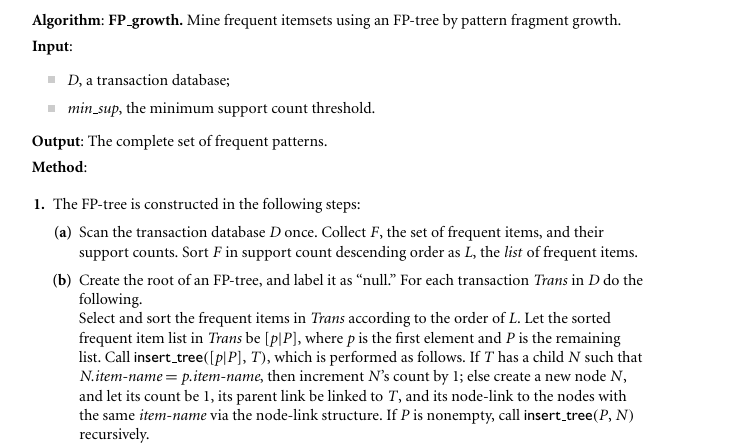

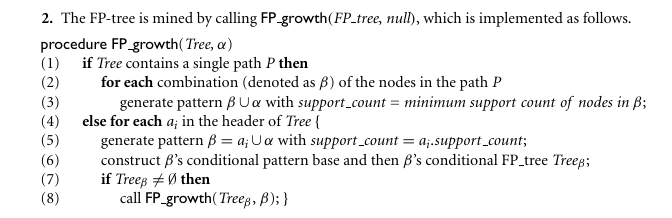

# Get Data

In [ ]:
from collections import defaultdict, OrderedDict
from csv import reader
from itertools import chain, combinations
from optparse import OptionParser
import numpy as np
import pandas as pd
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FPGrowth-Dataset/data2.csv', sep=" ", header=None)
print("\nDataset: \n", df)

Mounted at /content/drive

Dataset: 
                                            0
0                   1040,2372,2872,3159,4750
1         1040,1280,2495,2872,3186,4750,4995
2                             1040,2872,4750
3                        1280,2872,3186,4995
4                   1040,1280,2872,3186,4995
..                                       ...
269  1040,1280,2372,2872,3159,3186,4750,4995
270                 1040,2495,2872,4750,4995
271                      1280,2872,3186,4995
272                           1040,2872,4750
273                                1040,1280

[274 rows x 1 columns]


## Construct FP-Tree

In [ ]:
class Node:
    def __init__(self, item_name, frequency, parent_node):
        self.item_name = item_name
        self.count = frequency
        self.parent = parent_node
        self.children = {}
        self.next = None

In [ ]:
def Update_Tree(item, tree_node, header_table, frequency):
    if item in tree_node.children:
        # If the item already exists in the children, only increment the count on it
        tree_node.children[item].count += frequency
    else:
        # If the item doesn't exist, create a new branch for the item
        new_item_node = Node(item, frequency, tree_node)
        # make new_branch the child of the current item
        tree_node.children[item] = new_item_node

        # Link the new branch to header table (update header table)
        if header_table[item][1] == None:
            # add new node to item in hash table
            header_table[item][1] = new_item_node
        else:
            current_node = header_table[item][1]
            # Traverse to the last node then link it to the target
            while current_node.next != None:
                current_node = current_node.next
            current_node.next = new_item_node

    return tree_node.children[item]

In [ ]:
def Insert_Tree(itemset_list, frequency, min_sup):
    header_table = defaultdict(int)
    # Convert itemlist and frequencies into hashtable(dict)
    for idx, itemset in enumerate(itemset_list):
        for item in itemset:
            header_table[item] += frequency[idx]

    # Deleting items below min_sup
    header_table = dict((item, sup) for item, sup in header_table.items() if sup >= min_sup)
    
    # if there is no item above min_sup return None
    if(len(header_table) == 0):
        return None, None

    # add header table column for holding headNode (Item: [frequency, headNode])
    for item in header_table:
        header_table[item] = [header_table[item], None]

    # Create a Null head node
    fp_tree = Node('Null', 1, None)

    # Update FP tree for each cleaned and sorted itemset
    for idx, itemset in enumerate(itemset_list):
        # get itemset_list without deleted items in header_table
        itemset = [item for item in itemset if item in header_table]
        # sort items
        itemset.sort(key=lambda item: header_table[item][0], reverse=True)
        # select current node as null node (the begining of the tree)
        current_node = fp_tree
        # update tree with each item
        for item in itemset:
            current_node = Update_Tree(item, current_node, header_table, frequency[idx])

    return fp_tree, header_table

In [ ]:
def FP_tree(df, min_sup_ratio):
    itemset_list = []
    frequency = []
    
    # get frequency of lists
    for index, row in df.iterrows():
        row=list(row)[0].split(",")
        itemset_list.append(list(row))
        frequency.append(1)
    # print("\nFrequency                 Itemset List")
    # print("\n".join("     {}          {}".format(x, y) for x, y in zip(frequency, itemset_list)))

    # apply min_sup_ratio according to itemset_list size (274*0.5 = 137)
    min_sup = len(itemset_list) * min_sup_ratio
    print("Itemset lentght: ", len(itemset_list))
    print("Min ratio:       ", min_sup_ratio)
    print("Minsup:          ", min_sup)
    fp_tree, header_table = Insert_Tree(itemset_list, frequency, min_sup)
    return min_sup, header_table, fp_tree

In [ ]:
def Plot_Tree(fp_tree,  ind=1):
    print(ind, '  ' * ind, fp_tree.item_name, ' ', fp_tree.count)
    for child in list(fp_tree.children.values()):
        Plot_Tree(child, ind+1)

In [ ]:
min_sup, header_table, fp_tree = FP_tree(df, 0.5)

Itemset lentght:  274
Min ratio:        0.5
Minsup:           137.0


In [ ]:
print("Plot Tree:\n")
Plot_Tree(fp_tree)

Plot Tree:

1    Null   1
2      2872   227
3        1040   167
4          4750   157
5            1280   107
6              3186   89
7                4995   74
6              4995   15
5            3186   6
6              4995   4
5            4995   2
4          1280   7
5            3186   6
6              4995   6
3        1280   48
4          3186   45
5            4995   39
4          4995   2
3        4750   6
4          1280   5
5            3186   5
6              4995   5
3        3186   3
4          4995   2
2      1280   5
3        3186   5
4          4995   5
2      1040   38
3        4750   37
4          1280   5
5            3186   5
6              4995   4
4          3186   1
4          4995   1
3        1280   1
2      4995   1
2      4750   1


## FP-Treee mined by FPGrowth


In [ ]:
def Construct_Pattern_Base(base_pat, header_table):
    """
    Construct conditonal FP Tree with conditional pattern base
    """
    def Leaf_to_Root(node, prefix_path):
        if node.parent != None:
            prefix_path.append(node.item_name)
            Leaf_to_Root(node.parent, prefix_path)

    # First node in linked list
    tree_node = header_table[base_pat][1] 
    cond_Pats = []
    frequency = []
    while tree_node != None:
        prefix_path = []
        Leaf_to_Root(tree_node, prefix_path)  
        if len(prefix_path) > 1:
            # Storing the prefix path and it's corresponding count
            cond_Pats.append(prefix_path[1:])
            frequency.append(tree_node.count)

        # Go to next node
        tree_node = tree_node.next  
    return cond_Pats, frequency

In [ ]:
def FP_Growth(header_table, min_sup, prefix, freq_item_list):
    """
    Mine tree by FPGrowth
    """
    # Sort the items increasingly with frequency and create a list
    sorted_item_list = [item[0] for item in sorted(list(header_table.items()), key=lambda p:p[1][0])] 
    # Start with the lowest frequency
    for item in sorted_item_list:  
        # Pattern growth is achieved by the concatenation of suffix pattern with frequent patterns generated from conditional FP-tree
        new_freq_set = prefix.copy()
        new_freq_set.add(item)
        freq_item_list.append(new_freq_set)
        # Find all prefix path, constrcut conditional pattern base
        cond_pattern_base, frequency = Construct_Pattern_Base(item, header_table) 
        # Construct conditonal FP Tree with conditional pattern base
        conditional_tree, new_header_table = Insert_Tree(cond_pattern_base, frequency, min_sup) 
        if new_header_table != None:
            # FP_Growth recursively on the tree
            FP_Growth(new_header_table, min_sup,
                       new_freq_set, freq_item_list)

In [ ]:
def Mine(min_sup, header_table, fp_tree):
    freq_items = []
    FP_Growth(header_table, min_sup, set(), freq_items)
    return freq_items

In [ ]:
header_table

{'1040': [205, <__main__.Node at 0x7f0c2c34b2e8>],
 '1280': [178, <__main__.Node at 0x7f0c2c34b358>],
 '2872': [227, <__main__.Node at 0x7f0c2c34b2b0>],
 '3186': [165, <__main__.Node at 0x7f0c2c34b390>],
 '4750': [201, <__main__.Node at 0x7f0c2c34b320>],
 '4995': [160, <__main__.Node at 0x7f0c2c34b3c8>]}

In [ ]:
freq_itemset = Mine(min_sup, header_table, fp_tree)

In [ ]:
print("Frequent Item Set", *freq_itemset, sep = "\n") 

Frequent Item Set
{'4995'}
{'4995', '3186'}
{'4995', '2872'}
{'4995', '1280', '2872'}
{'4995', '1280'}
{'3186'}
{'3186', '2872'}
{'1280', '3186', '2872'}
{'1280', '3186'}
{'1280'}
{'1280', '2872'}
{'4750'}
{'4750', '2872'}
{'4750', '1040', '2872'}
{'4750', '1040'}
{'1040'}
{'1040', '2872'}
{'2872'}
